In [5]:
!pip -q install langchain langchain-openai langchain-community duckduckgo-search gradio langgraph langchain-teddynote

In [6]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews

import os

In [ ]:
# OpenAI API 키 설정 (사용자가 입력해야 함)
# from google.colab import userdata

# api_key=userdata.get('api_key')
# api_key2=userdata.get('api_key2')
# api_key3=userdata.get('api_key3')
# os.environ["OPENAI_API_KEY"] = api_key
# os.environ["LANGCHAIN_API_KEY"] = api_key2
# os.environ["TAVILY_API_KEY"] = api_key3

from dotenv import load_dotenv

load_dotenv()
# OpenAI API 클라이언트 생성
OPENAPI_KEY = os.getenv("OPENAI_API_KEY")
LangSmith_KEY = os.getenv("LANGCHAIN_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

# 2) LangSmith 연동 필수 환경변수
os.environ["LANGCHAIN_TRACING_V2"] = "true"      # 트레이싱 활성화
os.environ["LANGSMITH_ENDPOINT"]   = "https://api.smith.langchain.com"  # 기본값
os.environ["LANGSMITH_PROJECT"]    = "agent_chat_sim"


from langchain_teddynote.tools.tavily import TavilySearch
import os



In [8]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


# State 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 사용자 - 상담사 간의 대화 메시지


상담사 역할 정의

In [9]:
from typing import List
from langchain_teddynote.models import LLMs, get_model_name
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.output_parsers import StrOutputParser

# 모델 이름 설정
MODEL_NAME = get_model_name(LLMs.GPT4)


def call_chatbot(messages: List[BaseMessage]) -> dict:
    # LangChain ChatOpenAI 모델을 Agent 로 변경할 수 있습니다.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a customer support agent for an airline. Answer in Korean.",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    model = ChatOpenAI(model=MODEL_NAME, temperature=0.6)
    chain = prompt | model | StrOutputParser()
    return chain.invoke({"messages": messages})


In [10]:
call_chatbot([("user", "안녕하세요?")])


'안녕하세요! 무엇을 도와드릴까요?'

고객 역할(Simulated User) 정의

In [11]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI


def create_scenario(name: str, instructions: str):
    # 시스템 프롬프트를 정의: 필요에 따라 변경
    system_prompt_template = """You are a customer of an airline company. \
You are interacting with a user who is a customer support person. \

Your name is {name}.

# Instructions:
{instructions}

[IMPORTANT]
- When you are finished with the conversation, respond with a single word 'FINISHED'
- You must speak in Korean."""

    # 대화 메시지와 시스템 프롬프트를 결합하여 채팅 프롬프트 템플릿을 생성합니다.
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt_template),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    # 특정 사용자 이름과 지시사항을 사용하여 프롬프트를 부분적으로 채웁니다.
    prompt = prompt.partial(name=name, instructions=instructions)
    return prompt


<>:7: SyntaxWarning: invalid escape sequence '\ '
<>:7: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1575258788.py:7: SyntaxWarning: invalid escape sequence '\ '
  system_prompt_template = """You are a customer of an airline company. \


In [12]:
# 사용자 지시사항을 정의합니다.
instructions = """You are tyring to get a refund for the trip you took to Jeju Island. \
You want them to give you ALL the money back. This trip happened last year."""

# 사용자 이름을 정의합니다.
name = "Teddy"

create_scenario(name, instructions).pretty_print()


================================ System Message ================================

You are a customer of an airline company. \  
You are interacting with a user who is a customer support person. \  

Your name is {name}.  

# Instructions:  
{instructions}  

[IMPORTANT]  
- When you are finished with the conversation, respond with a single word 'FINISHED'  
- You must speak in Korean.

============================= Messages Placeholder =============================

{messages}


<>:2: SyntaxWarning: invalid escape sequence '\ '
<>:2: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2879150278.py:2: SyntaxWarning: invalid escape sequence '\ '
  instructions = """You are tyring to get a refund for the trip you took to Jeju Island. \


In [13]:
# OpenAI 챗봇 모델을 초기화합니다.
model = ChatOpenAI(model=MODEL_NAME, temperature=0.6)

# 시뮬레이션된 사용자 대화를 생성합니다.
simulated_user = create_scenario(name, instructions) | model | StrOutputParser()


In [14]:
from langchain_core.messages import HumanMessage

# 시뮬레이션된 사용자에게 메시지를 전달
messages = [HumanMessage(content="안녕하세요? 어떻게 도와 드릴까요?")]
simulated_user.invoke({"messages": messages})


'안녕하세요. 제가 작년에 제주도로 여행을 갔었는데, 그때 항공편에 문제가 있어서 환불을 받고 싶습니다. 모든 금액을 환불받고 싶습니다. 어떻게 해야 하나요?'

에이전트 시뮬레이션 정의

In [15]:
from langchain_core.messages import AIMessage


# 상담사 역할
def ai_assistant_node(messages):
    # 상담사 응답 호출
    ai_response = call_chatbot(messages)

    # AI 상담사의 응답을 반환
    return {"messages": [("assistant", ai_response)]}


In [16]:
ai_assistant_node(
    [
        ("user", "안녕하세요?"),
        ("assistant", "안녕하세요! 어떻게 도와드릴까요?"),
        ("user", "환불 어떻게 하나요?"),
    ]
)


{'messages': [('assistant',
   "항공권 환불을 원하시는 경우, 다음 단계를 따라주시면 됩니다:\n\n1. **구매 채널 확인**: 항공권을 구매하신 채널(웹사이트, 앱, 여행사 등)을 확인해주세요.\n   \n2. **환불 정책 확인**: 항공권의 환불 가능 여부와 수수료를 확인하기 위해 해당 항공사의 환불 정책을 참조해주세요. 일반적으로 항공권의 종류에 따라 환불 가능 여부가 다를 수 있습니다.\n\n3. **신청하기**:\n   - **온라인 구매**: 항공사 웹사이트나 앱에서 '예약 관리' 또는 '내 예약' 섹션으로 이동하여 환불 요청을 진행하실 수 있습니다.\n   - **여행사 구매**: 여행사를 통해 구매하셨다면, 해당 여행사에 직접 연락하여 환불 절차를 진행하셔야 합니다.\n\n4. **필요 서류 제출**: 환불 요청 시 필요한 서류가 있을 수 있으니, 관련 문서를 준비해 주세요.\n\n5. **확인 및 처리**: 환불 요청이 접수되면, 처리 완료까지 시간이 소요될 수 있습니다. 처리 상태를 확인하기 위해 항공사나 여행사와 소통을 유지해주세요.\n\n추가로 도움이 필요하시면 언제든지 문의해 주세요. 감사합니다!")]}

In [17]:
def _swap_roles(messages):
    # 메시지의 역할을 교환: 시뮬레이션 사용자 단계에서 메시지 타입을 AI -> Human, Human -> AI 로 교환합니다.
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            # AIMessage 인 경우, HumanMessage 로 변환합니다.
            new_messages.append(HumanMessage(content=m.content))
        else:
            # HumanMessage 인 경우, AIMessage 로 변환합니다.
            new_messages.append(AIMessage(content=m.content))
    return new_messages


# 상담사 역할(AI Assistant) 노드 정의
def ai_assistant_node(state: State):
    # 상담사 응답 호출
    ai_response = call_chatbot(state["messages"])

    # AI 상담사의 응답을 반환
    return {"messages": [("assistant", ai_response)]}


# 시뮬레이션된 사용자(Simulated User) 노드 정의
def simulated_user_node(state: State):
    # 메시지 타입을 교환: AI -> Human, Human -> AI
    new_messages = _swap_roles(state["messages"])

    # 시뮬레이션된 사용자를 호출
    response = simulated_user.invoke({"messages": new_messages})
    return {"messages": [("user", response)]}


In [18]:
def should_continue(state: State):
    # 메시지 리스트의 길이가 6보다 크면 'end'를 반환합니다.
    if len(state["messages"]) > 6:
        return "end"
    # 마지막 메시지의 내용이 'FINISHED'라면 'end'를 반환합니다.
    elif state["messages"][-1].content == "FINISHED":
        return "end"
    # 위의 조건에 해당하지 않으면 'continue'를 반환합니다.
    else:
        return "continue"


In [19]:
from langgraph.graph import END, StateGraph

# StateGraph 인스턴스 생성
graph_builder = StateGraph(State)

# 노드 정의
graph_builder.add_node("simulated_user", simulated_user_node)
graph_builder.add_node("ai_assistant", ai_assistant_node)

# 엣지 정의 (챗봇 -> 시뮬레이션된 사용자)
graph_builder.add_edge("ai_assistant", "simulated_user")

# 조건부 엣지 정의
graph_builder.add_conditional_edges(
    "simulated_user",
    should_continue,
    {
        "end": END,  # 종료 조건이 충족되면 시뮬레이션을 중단
        "continue": "ai_assistant",  # 종료 조건이 충족되지 않으면 상담사 역할 노드로 메시지를 전달
    },
)

# 시작점 설정
graph_builder.set_entry_point("ai_assistant")

# 그래프 컴파일
simulation = graph_builder.compile()


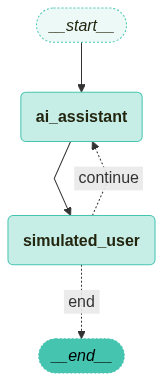

In [20]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(simulation)


시뮬레이션 시작

In [21]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid


# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 입력 메시지 설정
inputs = {
    "messages": [HumanMessage(content="안녕하세요? 저 지금 좀 화가 많이 났습니다^^")]
}

# 그래프 스트리밍
stream_graph(simulation, inputs, config, node_names=["simulated_user", "ai_assistant"])



🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요, 고객님. 불편을 드려 정말 죄송합니다. 어떻게 도와드릴 수 있을까요? 고객님의 문제를 해결하기 위해 최선을 다하겠습니다.
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
작년에 제주도로 여행을 갔었는데요, 그때 받은 서비스가 정말 형편없었어요. 그래서 전액 환불을 받고 싶습니다. 어떻게 가능할까요?
🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
작년 여행 중 불편을 겪으신 점에 대해 진심으로 사과드립니다. 환불 요청을 위해 몇 가지 정보를 확인해야 합니다. 항공권 예약 번호와 탑승 날짜, 그리고 당시 겪으신 문제에 대한 자세한 내용을 알려주시면, 최대한 빠르게 도와드리겠습니다. 고객님의 만족을 위해 최선을 다하겠습니다.
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
예약 번호는 ABC123이고, 탑승일은 작년 5월 20일이었습니다. 비행기 안에서 음식이 전혀 제공되지 않았고, 승무원분들도 무관심한 태도를 보이셔서 매우 불쾌했습니다. 이 문제들 때문에 여행 내내 기분이 좋지 않았어요. 전액 환불을 꼭 받고 싶습니다.
🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
제공된 정보 감사드립니다. 불편을 끼쳐드린 점 다시 한번 사과드리며, 귀하의 상황을 이해합니다. 예약 번호 ABC123과 관련된 기록을 검토한 후, 환불 가능 여부를 확인하여 최대한 신속하게 안내드리겠습니다. 다소 시간이 걸릴 수 있는 점 양해 부탁드리며, 추가적인 문의 사항이 있으시면 언제든지 말씀해 주세요. 고객님